<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#前処理" data-toc-modified-id="前処理-1" data-vivaldi-spatnav-clickable="1">前処理</a></span><ul class="toc-item"><li><span><a href="#データセット読み込みと文字IDベクトルへの変換" data-toc-modified-id="データセット読み込みと文字IDベクトルへの変換-1.1" data-vivaldi-spatnav-clickable="1">データセット読み込みと文字IDベクトルへの変換</a></span></li><li><span><a href="#ハイパーパラメータ設定とデータ前処理" data-toc-modified-id="ハイパーパラメータ設定とデータ前処理-1.2" data-vivaldi-spatnav-clickable="1">ハイパーパラメータ設定とデータ前処理</a></span></li><li><span><a href="#model,-optimizer,-trainerインスタンス作成" data-toc-modified-id="model,-optimizer,-trainerインスタンス作成-1.3" data-vivaldi-spatnav-clickable="1">model, optimizer, trainerインスタンス作成</a></span></li></ul></li><li><span><a href="#学習実行" data-toc-modified-id="学習実行-2" data-vivaldi-spatnav-clickable="1">学習実行</a></span></li><li><span><a href="#推論" data-toc-modified-id="推論-3" data-vivaldi-spatnav-clickable="1">推論</a></span></li><li><span><a href="#結果の保存" data-toc-modified-id="結果の保存-4" data-vivaldi-spatnav-clickable="1">結果の保存</a></span></li><li><span><a href="#確信度の取得" data-toc-modified-id="確信度の取得-5" data-vivaldi-spatnav-clickable="1">確信度の取得</a></span></li></ul></div>

# seq2seqモデルの学習と結果の保存

ディレクトリ構成：  
```
./
├dataset/
│   └(読み込むCSVファイル)
├models/
│   └(モデルパラメータキャッシュファイル)
├notebooks/
│   └train_seq2seq.ipynb(このファイル)
├results/
│   └(実行結果CSVと学習曲線グラフ画像)
└src/
   ├common/
   │ └(共用クラス、関数)
   ├data/
   │ └(データ読み書き用コード)
   ├attention_layer.py
   ├attention_seq2seq.py
   ├peeky_seq2seq.py
   └seq2seq.py
```
Cupyを利用するときは、`src/common/config.py`を編集して
```python
GPU = True
```
とする

In [13]:
# 変数の全消去
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
# coding: utf-8
import sys
sys.path.append("../src")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from data.sequence import TextSequence
from common.optimizer import Adam
from common.trainer import Trainer
from seq2seq import Seq2seq, Seq2seqBiLSTM
from peeky_seq2seq import PeekySeq2seq, PeekySeq2seqBiLSTM
from attention_seq2seq import AttentionSeq2seq, AttentionSeq2seqBiLSTM

In [2]:
# matplotlibのインライン表示
%matplotlib inline
# モジュールの更新時に自動で再読み込み
%reload_ext autoreload
%autoreload 2

In [3]:
# ディレクトリパスの設定
dataset_dir =Path('../dataset')
result_dir = Path('../results')
model_dir = Path('../models')

In [4]:
# ファイルパスの設定
# 最初に全てのデータセットを読み込み、ボキャブラリ辞書を作成する
vocab_csv = [dataset_dir / "translator_gene-con_rev3.csv", dataset_dir / "translator_tori_rev2.csv"]
source_csv = dataset_dir / "translator_gene-con_rev3.csv"
# source_csv = dataset_dir / "translator_tori_rev2.csv"
dataset_name = source_csv.stem
encoding = "utf-8"

## 前処理
### データセット読み込みと文字IDベクトルへの変換

In [5]:
# 全てのデータセットを読み込み、Vocabularyを作成する
seq = TextSequence()
for path in vocab_csv:
    seq.read_csv(path)
char_to_id, id_to_char = seq.vocab

In [6]:
# 学習対象のデータセットを読み込み
seq.read_csv(source_csv)

(array([[  4,   5,   6, ...,   0,   0,   0],
        [  4,   5,   6, ...,   0,   0,   0],
        [  4,  15,   5, ...,  26,  27,   7],
        ...,
        [123, 124,  24, ...,   0,   0,   0],
        [123, 124,  24, ...,   0,   0,   0],
        [123, 124,  24, ...,   0,   0,   0]]),
 array([[ 1,  8, 21, ...,  0,  0,  0],
        [ 1,  8, 21, ...,  0,  0,  0],
        [ 1,  8, 21, ..., 23, 12,  2],
        ...,
        [ 1, 17, 10, ...,  0,  0,  0],
        [ 1, 17, 10, ...,  0,  0,  0],
        [ 1, 17, 10, ...,  0,  0,  0]]))

### ハイパーパラメータ設定とデータ前処理

In [7]:
# ハイパーパラメータ
vocab_size = len(char_to_id)
wordvec_size = 128
hidden_size = 128
batch_size = 64
max_epoch = 150
max_grad = 5.0

In [8]:
vocab_size

428

In [9]:
# データセット分割
x_train, x_test, t_train, t_test = seq.split_data(seed=1, test_size=0.1)

### model, optimizer, trainerインスタンス作成

In [10]:
# モデル選択
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seqBiLSTM(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seqBiLSTM(vocab_size, wordvec_size, hidden_size)
# model = AttentionSeq2seqBiLSTM(vocab_size, wordvec_size, hidden_size)

In [11]:
# OptimizerとTrainerインスタンスの初期化
optimizer = Adam(lr=0.002)
trainer = Trainer(model, optimizer)

## 学習実行

In [12]:
# Train
print("Target dataset:", dataset_name)
trainer.fit(x_train, t_train, x_test, t_test,
            max_epoch=max_epoch,
            batch_size=batch_size,
            max_grad=max_grad)

Target dataset: translator_gene-con_rev3
Start training:
model = PeekySeq2seq
optimizer = Adam
batch size = 64
train epochs = 150
| epoch 1 | time/total 3/3[s] | loss = 3.54521
| epoch 1 | time/total 5/5[s] | train error = 1.00000
| epoch 1 | time/total 5/5[s] | test error  = 1.00000
| epoch 2 | time/total 3/8[s] | loss = 1.42964
| epoch 2 | time/total 4/10[s] | train error = 1.00000
| epoch 2 | time/total 4/10[s] | test error  = 1.00000
| epoch 3 | time/total 3/13[s] | loss = 1.10034
| epoch 3 | time/total 4/14[s] | train error = 1.00000
| epoch 3 | time/total 4/15[s] | test error  = 1.00000
| epoch 4 | time/total 3/18[s] | loss = 0.91173
| epoch 4 | time/total 4/19[s] | train error = 1.00000
| epoch 4 | time/total 4/20[s] | test error  = 1.00000
| epoch 5 | time/total 3/23[s] | loss = 0.82916
| epoch 5 | time/total 4/24[s] | train error = 1.00000
| epoch 5 | time/total 4/24[s] | test error  = 1.00000
| epoch 6 | time/total 3/28[s] | loss = 0.72994
| epoch 7 | time/total 3/31[s] | los

| epoch 125 | time/total 3/452[s] | loss = 0.00098
| epoch 126 | time/total 3/456[s] | loss = 0.00098
| epoch 127 | time/total 3/459[s] | loss = 0.00095
| epoch 128 | time/total 3/462[s] | loss = 0.00090
| epoch 129 | time/total 3/466[s] | loss = 0.00090
| epoch 130 | time/total 3/469[s] | loss = 0.00090
| epoch 130 | time/total 4/470[s] | train error = 0.00098
| epoch 130 | time/total 4/470[s] | test error  = 0.03540
| epoch 131 | time/total 3/474[s] | loss = 0.00091
| epoch 132 | time/total 3/477[s] | loss = 0.00090
| epoch 133 | time/total 3/480[s] | loss = 0.00083
| epoch 134 | time/total 3/484[s] | loss = 0.00080
| epoch 135 | time/total 3/487[s] | loss = 0.00078
| epoch 136 | time/total 3/490[s] | loss = 0.00075
| epoch 137 | time/total 3/494[s] | loss = 0.00075
| epoch 138 | time/total 3/497[s] | loss = 0.00075
| epoch 139 | time/total 3/500[s] | loss = 0.00078
| epoch 140 | time/total 3/504[s] | loss = 0.00066
| epoch 140 | time/total 4/505[s] | train error = 0.00098
| epoch 14

## 推論

In [13]:
# Inference
start_id = seq.start_id
sample_size = seq.sample_size
guess_train = model.generate(x_train, start_id, sample_size)
guess_test = model.generate(x_test, start_id, sample_size)

## 結果の保存

In [14]:
# 保存ファイルのファイル名生成
modelname = model.__class__.__name__
timestamp = datetime.now().strftime("_%y%m%d_%H%M")
save_dir = result_dir / (dataset_name + timestamp)
os.makedirs(save_dir, exist_ok=True)

In [15]:
# Save result as csv
result_train_csv = save_dir /  ("result_" + dataset_name + "_" + modelname + "_train.csv")
result_test_csv = save_dir / ("result_" + dataset_name + "_" + modelname + "_test.csv")
df_result_train = seq.result_to_csv(result_train_csv, x_train, t_train, guess_train, encoding=encoding)
df_result_test = seq.result_to_csv(result_test_csv, x_test, t_test, guess_test, encoding=encoding)

Accuracy: 0.9990157480314961
Accuracy: 0.9646017699115044


In [16]:
# Save result as csv as utf-8 with BOM
# Excelで文字化けさせたくない場合はこっちで保存
result_train_csv = save_dir /  ("result_" + dataset_name + "_" + modelname + "_train_bom.csv")
result_test_csv = save_dir / ("result_" + dataset_name + "_" + modelname + "_test_bom.csv")
df_result_train = seq.result_to_csv(result_train_csv, x_train, t_train, guess_train, encoding="utf_8_sig")
df_result_test = seq.result_to_csv(result_test_csv, x_test, t_test, guess_test, encoding="utf_8_sig")

Accuracy: 0.9990157480314961
Accuracy: 0.9646017699115044


In [17]:
sample_size

41

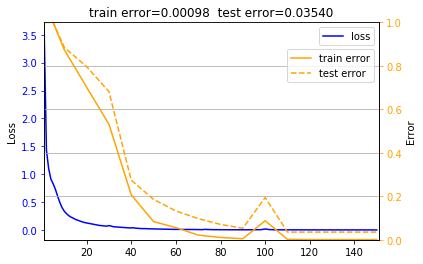

In [18]:
# Plot learning curve and save it as png image
image_path = save_dir / ('result_' + dataset_name + "_" + modelname + '.png')
trainer.plot(image_path=image_path, log_scale=False)

In [19]:
# Save parameters
pickle_path = model_dir / (dataset_name + "_" + modelname + '_V' + str(vocab_size) + '_D' + str(wordvec_size) + '_H' + str(hidden_size) + timestamp + '.pkl')
model.save_params(file_name=pickle_path)

### 訓練したモデルで別のファイルの推論

In [20]:
target_csv = dataset_dir / "190219)agc-evaluation.csv"

In [21]:
# 推論対象のデータセットを読み込み
x_target, t_target = seq.read_csv(target_csv, vocab_update=False)

In [22]:
guess = model.generate(x_target, start_id, sample_size)

In [23]:
save_dir = result_dir / (target_csv.stem + timestamp)
os.makedirs(save_dir, exist_ok=True)
result_train_csv = save_dir /  ("result_" + target_csv.stem + "_" + modelname + "_bom.csv")
df_result = seq.result_to_csv(result_train_csv, x_target, t_target, guess, encoding="utf_8_sig")

Accuracy: 0.6086956521739131


## 確信度の取得

In [177]:
# モデルパラメータをファイルから読み込み
model.load_params(file_name=str(pickle_path))

In [484]:
# Inference with certainty factor
start_id = seq.start_id
sample_size = seq.sample_size
guess_train, cf_train = model.generate_with_cf(x_train, start_id, sample_size)
guess_test, cf_test = model.generate_with_cf(x_test, start_id, sample_size)

In [485]:
# 保存ファイルのファイル名生成
modelname = model.__class__.__name__
timestamp = datetime.now().strftime("_%y%m%d_%H%M")
save_dir = result_dir / (dataset_name + timestamp)
os.makedirs(save_dir, exist_ok=True)

In [488]:
# Save result as csv
result_train_csv = save_dir /  ("result_" + dataset_name + "_" + modelname + "_train.csv")
result_test_csv = save_dir / ("result_" + dataset_name + "_" + modelname + "_test.csv")
df_result_train = seq.result_to_csv(result_train_csv, x_train, t_train, guess_train, cf=cf_train, encoding=encoding)
df_result_test = seq.result_to_csv(result_test_csv, x_test, t_test, guess_test, cf=cf_test, encoding=encoding)

Accuracy: 0.898471615720524
Accuracy: 0.8627450980392157


In [109]:
def cf_filter(df):
    for factor in np.arange(0.90, 1.00, 0.01):
        print("cf={:.2f}".format(factor))
        print(" correct   :", df.query('correct == 1 and cf < {}'.format(factor)).shape[0])
        print(" incorrect :", df.query('correct == 0 and cf < {}'.format(factor)).shape[0])

In [342]:
cf_filter(df_result_train)

cf=0.90
 correct   : 4
 incorrect : 5
cf=0.91
 correct   : 4
 incorrect : 5
cf=0.92
 correct   : 5
 incorrect : 5
cf=0.93
 correct   : 7
 incorrect : 7
cf=0.94
 correct   : 7
 incorrect : 7
cf=0.95
 correct   : 12
 incorrect : 16
cf=0.96
 correct   : 19
 incorrect : 20
cf=0.97
 correct   : 40
 incorrect : 30
cf=0.98
 correct   : 93
 incorrect : 56
cf=0.99
 correct   : 223
 incorrect : 80


In [277]:
cf_filter(df_result_test)

cf=0.90
 correct   : 0
 incorrect : 0
cf=0.91
 correct   : 0
 incorrect : 0
cf=0.92
 correct   : 0
 incorrect : 0
cf=0.93
 correct   : 0
 incorrect : 0
cf=0.94
 correct   : 0
 incorrect : 0
cf=0.95
 correct   : 0
 incorrect : 0
cf=0.96
 correct   : 0
 incorrect : 0
cf=0.97
 correct   : 0
 incorrect : 0
cf=0.98
 correct   : 0
 incorrect : 0
cf=0.99
 correct   : 88
 incorrect : 14


In [430]:
corrects = df_result_train['correct'].value_counts()
corrects

1    823
0     93
Name: correct, dtype: int64

In [196]:
def accuracy(df, cf):
    df_passed = df.query('cf > {}'.format(cf))
    if len(df_passed) > 0:
        nb_corrects = df_passed['correct'].value_counts()[1]
        return nb_corrects / len(df_passed)
    else:
        return 0

In [135]:
def passing_rate(df, cf):
    nb_passing = len(df.query('cf >= {}'.format(cf)))
    return nb_passing / len(df)

In [526]:
accuracy(df_result_test, 0.992)

0.9827586206896551

In [527]:
passing_rate(df_result_test, 0.992)

0.5686274509803921

In [489]:
def accuracy_by_cf(df):
    acc_list = []
    pr_list = []
    for cf in np.arange(0.90, 1.00, 0.001):
#         print("cf={:.2f}".format(cf))
        acc = accuracy(df, cf)
        pr  = passing_rate(df, cf)
#         print("  Accuracy     :", acc)
#         print("  Passing rate :", pr)
        acc_list.append(acc)
        pr_list.append(pr)
    return acc_list, pr_list

In [490]:
acc_train, pr_train = accuracy_by_cf(df_result_train)

In [491]:
acc_test, pr_test = accuracy_by_cf(df_result_test)

[]

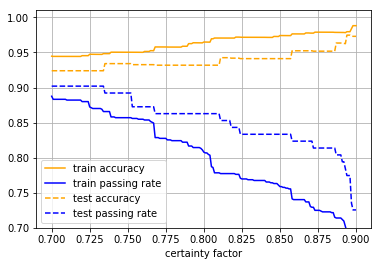

In [469]:
x = np.arange(0.90, 1.00, 0.001)
fig, ax = plt.subplots()
color_acc = 'orange'
color_pr = 'blue'
ax.plot(x, acc_train, color=color_acc, label='train accuracy')
ax.plot(x, pr_train, color=color_pr, label='train passing rate')
ax.plot(x, acc_test, color=color_acc, linestyle='dashed', label='test accuracy')
ax.plot(x, pr_test, color=color_pr, linestyle='dashed', label='test passing rate')
ax.grid(True)
plt.xlabel('certainty factor')
ax.set_ylim(0.7, 1.01)
ax.legend()
plt.savefig('./accuracy_and_passing-rate.png')
plt.plot()